多个支持向量存在的理由

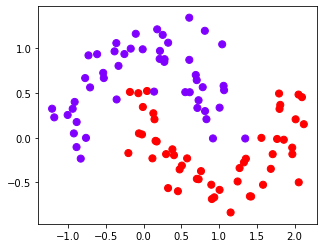

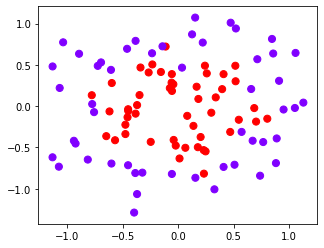

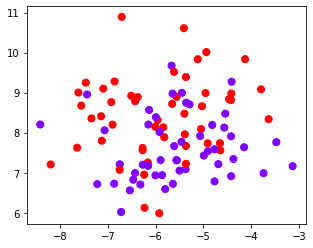

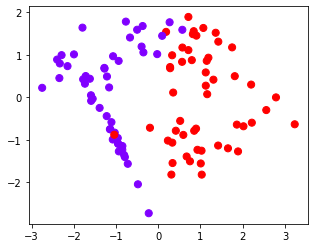

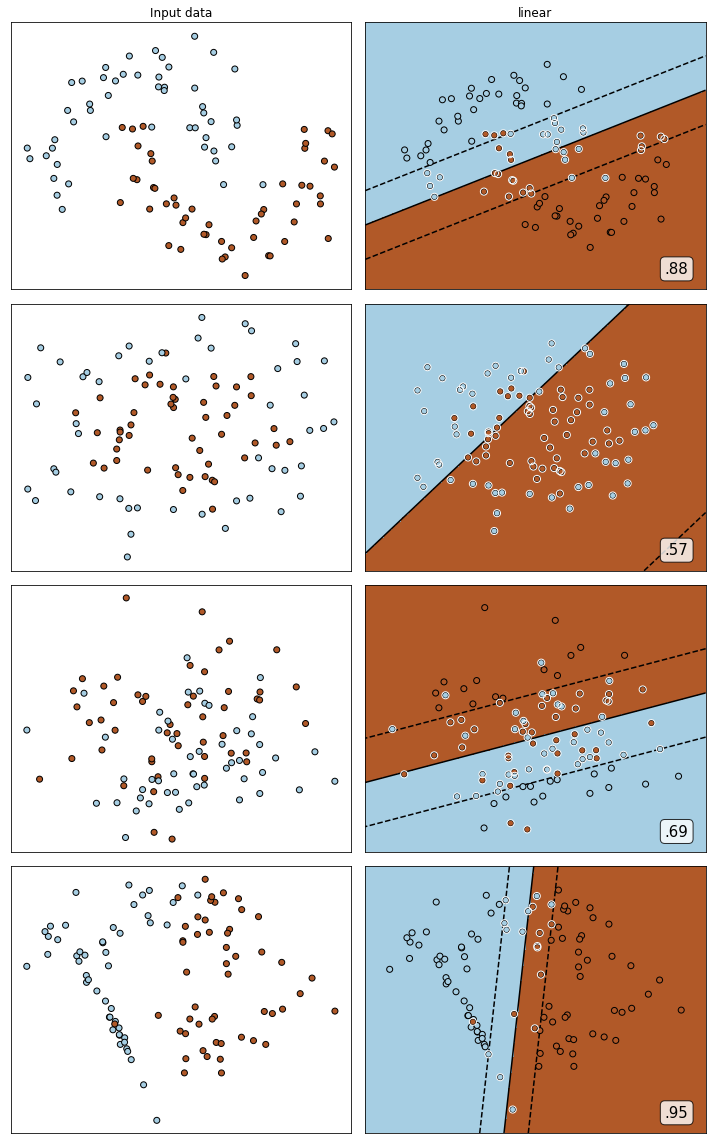

In [1]:
# 1、导入所需要的类和模块

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap   #
from sklearn.svm import SVC
from sklearn.datasets import make_circles, make_moons, make_blobs,make_classification
# 2、创建数据集，定义核函数的选择

n_samples = 100
datasets = [
    make_moons(n_samples=n_samples, noise=0.2, random_state=0),
    make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1),
#     混杂数据集 不好分
    make_blobs(n_samples=n_samples, centers=2, random_state=5),
    make_classification(n_samples=n_samples,n_features = 2,n_informative=2,n_redundant=0, random_state=5)
    # n_informative指带信息的特征有几个,n_redundant指不带信息的特征有几个 2-2=0
 ]
Kernel = ["linear"] 
for X,Y in datasets:
    plt.figure(figsize=(5,4))
    plt.scatter(X[:,0],X[:,1],c=Y,s=50,cmap="rainbow")
# 3. 构建子图
nrows=len(datasets)
ncols=len(Kernel) + 1
fig, axes = plt.subplots(nrows, ncols,figsize=(10,16))

#第一层循环：在不同的数据集中循环
for ds_cnt, (X,Y) in enumerate(datasets):
    #在图像中的第一列，放置原数据的分布
    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
#   zorder散点图放在最上面，数字越大越优先
    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,edgecolors='k') # zorder 是指将值显示在上面的参数，zorder越大，显示的位置越在上面。
    ax.set_xticks(())
    ax.set_yticks(())

    #第二层循环：在不同的核函数中循环
    #从图像的第二列开始，一个个填充分类结果
    for est_idx, kernel in enumerate(Kernel):

        #定义子图位置
        ax = axes[ds_cnt, est_idx + 1]

        #建模
        clf = SVC(kernel=kernel, gamma=2).fit(X, Y) # 训练，建立决策边界
        score = clf.score(X, Y)

        #绘制图像本身分布的散点图
        ax.scatter(X[:, 0], X[:, 1], c=Y,zorder=10,cmap=plt.cm.Paired,edgecolors='k')
        #绘制支持向量
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=50,
                    facecolors='none', zorder=10, edgecolors='white')

        #绘制决策边界 有边界
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

        #np.mgrid，合并了我们之前使用的np.linspace和np.meshgrid的用法
        #一次性使用最大值和最小值来生成网格
        #表示为[起始值：结束值：步长]
        #如果步长是复数，则其整数部分就是起始值和结束值之间创建的点的数量，并且结束值被包含在内
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        #np.c_，类似于np.vstack的功能  网格坐标。decision_function计算点的距离
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        #填充等高线不同区域的颜色
        ax.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
        #绘制等高线
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-1, 0, 1])

        #设定坐标轴为不显示
        ax.set_xticks(())
        ax.set_yticks(())

        #将标题放在第一行的顶上
        if ds_cnt == 0:
            ax.set_title(kernel)

        #为每张图添加分类的分数，1横坐标的位置，2纵坐标的位置，3要填的内容 ；lstrip('0')是只显示点后面的小数  
        ax.text(0.95, 0.06, ('%.2f' % score).lstrip('0')
               , size=15
               , bbox=dict(boxstyle='round', alpha=0.8, facecolor='white')
               #为分数添加一个白色的格子作为底色
               , transform=ax.transAxes  #确定文字所对应的坐标轴，就是ax子图的坐标轴本身
               , horizontalalignment='right' #位于坐标轴的什么方向
               )
# 图像之间是紧缩显示
plt.tight_layout()
plt.show()

两条虚线超平面之间的所有点都是支持向量，虚线超平面之外的异常点也是支持向量，但是误差大，不选择。

二分类SVC中的样本不均衡问题：重要参数class_weight

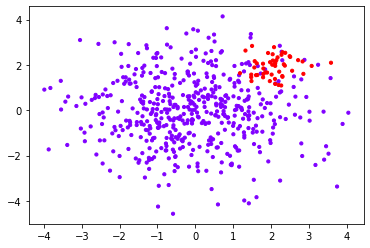

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

#看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10);
#其中红色点是少数类，紫色点是多数类

In [3]:
#不设定class_weight
clf = SVC(kernel='linear', C=1.0)
clf.fit(X, y)
#给两个模型分别打分看看，这个分数是accuracy准确度
# 不设置class_weight时的准确度高
clf.score(X,y)

0.9418181818181818

In [4]:
#设定class_weight
wclf = SVC(kernel='linear', class_weight={1: 10})
wclf.fit(X, y)
wclf.score(X,y)

0.9127272727272727

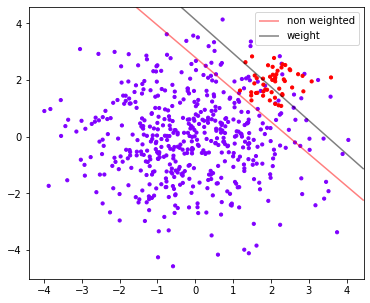

In [5]:
# 首线有数据分布
plt.figure(figsize=(6,5))
plt.scatter(X[:,0],X[:,1],c=y,cmap='rainbow',s=10)
# 获取当前子图，如果不存在则创建新的子图
ax=plt.gca()

xlim=ax.get_xlim()
ylim=ax.get_ylim()
# 第一步有网格
xx=np.linspace(xlim[0],xlim[1],30)
yy=np.linspace(ylim[0],ylim[1],30)
YY,XX=np.meshgrid(yy,xx)
xy=np.vstack([XX.ravel(),YY.ravel()]).T

# 第二步 样本点到决策边界的距离
Z_wclf = wclf.decision_function(xy).reshape(XX.shape)
a=ax.contour(XX,YY,Z_wclf,colors='red',levels=[0],alpha=0.5,linestyles=['-'])

Z_clf = clf.decision_function(xy).reshape(XX.shape)
b=ax.contour(XX,YY,Z_clf,colors='black',levels=[0],alpha=0.5,linestyles=['-'])

# 第三步 画图例
# a.collections 等高线对象中所有的线对象
plt.legend([a.collections[0],b.collections[0]],['non weighted','weight'],loc='upper right')
plt.show()


![title](C:\Users\Administrator\caicaidata\jietu\class_weight.jpg)

SVC模型评估指标  需要捕获少数类的能力和将多数类判错后需要付出的成本的平衡       混淆矩阵和ROC曲线

![title](C:\Users\Administrator\caicaidata\jietu\hunxiaojuzhen.jpg)

![title](C:\Users\Administrator\caicaidata\jietu\zhunquelv.jpg)

![title](C:\Users\Administrator\caicaidata\jietu\jingquedu.jpg)

In [6]:
# 所有判断正确并确实为1的样本/所有被判断为1的样本
# 对于没有class_weight，没有做样本平衡的灰色决策边界来说
(y[y==clf.predict(X)]==1).sum()/(clf.predict(X)==1).sum()

0.7142857142857143

In [7]:
# 真实值等于预测值的全部点
y==clf.predict(X)

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [8]:
# 对于有class_weight，没有做样本平衡的灰色决策边界来说
(y[y==wclf.predict(X)]==1).sum()/(wclf.predict(X)==1).sum()

0.5102040816326531

![title](C:\Users\Administrator\caicaidata\jietu\jingquedu1.jpg)

![title](C:\Users\Administrator\caicaidata\jietu\zhaohuilv.jpg)

In [9]:
# 所有predict为1的点 /全部为1的点的比例
# 对于没有class_weight，没有做样本平衡的灰色决策边界来说
(y[y==clf.predict(X)]==1).sum()/(y==1).sum()

0.6

In [10]:
# 对于有class_weight，没有做样本平衡的灰色决策边界来说
(y[y==wclf.predict(X)]==1).sum()/(y==1).sum()

1.0

![title](C:\Users\Administrator\caicaidata\jietu\f1fenshu.jpg)

![title](C:\Users\Administrator\caicaidata\jietu\jiafulv.jpg)

![title](C:\Users\Administrator\caicaidata\jietu\teyidu.jpg)

In [11]:
# 所有被正确预测为0的样本/所有为0的样本
# 没有class_weight
(y[y==clf.predict(X)]==0).sum()/(y==0).sum()

0.976

In [12]:
# 有class_weight
(y[y==wclf.predict(X)]==0).sum()/(y==0).sum()

0.904

![title](C:\Users\Administrator\caicaidata\jietu\jiazhenglv.jpg)

![title](C:\Users\Administrator\caicaidata\jietu\hunxiaojuzhen1.jpg)

![title](C:\Users\Administrator\caicaidata\jietu\roc.jpg)

SVM概率与阈值

![title](C:\Users\Administrator\caicaidata\jietu\gailvyuyuzhi.jpg)

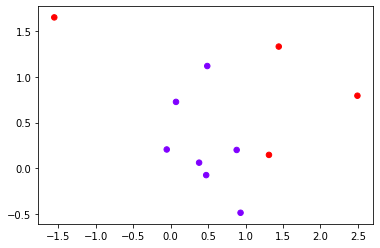

In [14]:
class_1_=7
class_2_=4
centers_=[[0.0,0.0],[1,1]]
clusters_std=[0.5,1]
X_,y_=make_blobs(n_samples=[class_1_,class_2_],centers=centers_
                 ,cluster_std=clusters_std,random_state=0,shuffle=False)
plt.scatter(X_[:,0],X_[:,1],c=y_,cmap='rainbow',s=30)
plt.show()

In [15]:
from sklearn.linear_model import LogisticRegression
clf_lo=LogisticRegression().fit(X_,y_)
prob=clf_lo.predict_proba(X_)

In [16]:
prob

array([[0.69461879, 0.30538121],
       [0.5109308 , 0.4890692 ],
       [0.82003826, 0.17996174],
       [0.78564706, 0.21435294],
       [0.77738721, 0.22261279],
       [0.65663421, 0.34336579],
       [0.76858638, 0.23141362],
       [0.34917129, 0.65082871],
       [0.36618382, 0.63381618],
       [0.66327186, 0.33672814],
       [0.6075288 , 0.3924712 ]])

In [17]:
import pandas as pd
prob=pd.DataFrame(prob)

In [18]:
prob.columns=['0','1']

In [19]:
prob

,0,1
0,0.694619,0.305381
1,0.510931,0.489069
2,0.820038,0.179962
3,0.785647,0.214353
4,0.777387,0.222613
5,0.656634,0.343366
6,0.768586,0.231414
7,0.349171,0.650829
8,0.366184,0.633816
9,0.663272,0.336728


使用阈值0.5，大于0.5预测为1，小于0.5预测为0

In [20]:
for i in range(prob.shape[0]):
    if prob.loc[i,'1']>0.5:
        prob.loc[i,'pred']=1
    else:
        prob.loc[i,'pred']=0
prob['y_true']=y_
prob=prob.sort_values(by='1',ascending=False)

In [21]:
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,0.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


In [22]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score

In [23]:
confusion_matrix(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])

array([[2, 2],
       [0, 7]], dtype=int64)

In [24]:
# 计算Precision labels少数类卸载前面
precision_score(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])

1.0

In [25]:
# 计算recall
recall_score(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])

0.5

使用阈值0.4，大于0.4预测为1，小于0.4预测为0

In [26]:
for i in range(prob.shape[0]):
    if prob.loc[i,'1']>0.4:
        prob.loc[i,'pred']=1
    else:
        prob.loc[i,'pred']=0

In [27]:
prob

,0,1,pred,y_true
7,0.349171,0.650829,1.0,1
8,0.366184,0.633816,1.0,1
1,0.510931,0.489069,1.0,0
10,0.607529,0.392471,0.0,1
5,0.656634,0.343366,0.0,0
9,0.663272,0.336728,0.0,1
0,0.694619,0.305381,0.0,0
6,0.768586,0.231414,0.0,0
4,0.777387,0.222613,0.0,0
3,0.785647,0.214353,0.0,0


In [28]:
confusion_matrix(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])

array([[2, 2],
       [1, 6]], dtype=int64)

In [29]:
# 计算Precision labels少数类卸载前面
precision_score(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])

0.6666666666666666

In [30]:
# 计算recall
recall_score(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])

0.5

注意：调整阈值后，Precision下降了，但是recall没变。降低或者升高阈值并不一定能够让模型效果更好，一切都基于我们追求怎样的模型效果。通常来说，降低阈值能够升高recall

![title](C:\Users\Administrator\caicaidata\jietu\svmgailv.jpg)

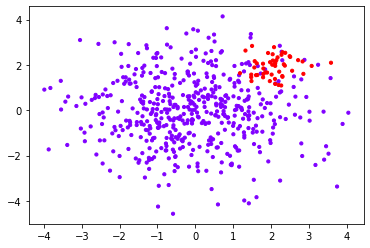

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

#看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10);
#其中红色点是少数类，紫色点是多数类

In [32]:
clf_proba=SVC(kernel='linear',C=1.0,probability=True).fit(X,y)

In [33]:
clf_proba.predict_proba(X).shape

(550, 2)

In [34]:
# 返回每个标签的概率
clf_proba.predict_proba(X)

array([[0.69716182, 0.30283818],
       [0.28163312, 0.71836688],
       [0.96239142, 0.03760858],
       ...,
       [0.17059707, 0.82940293],
       [0.37354518, 0.62645482],
       [0.33496575, 0.66503425]])

In [35]:
# 置信度 距离 
clf_proba.decision_function(X).shape

(550,)

![title](C:\Users\Administrator\caicaidata\jietu\gailvzongjie.jpg)

绘制ROC曲线

In [36]:
cm=confusion_matrix(prob.loc[:,'y_true'],prob.loc[:,'pred'],labels=[1,0])

In [37]:
cm

array([[2, 2],
       [1, 6]], dtype=int64)

In [38]:
# FPR 假正率 即是 1-特异度     特异度 是 00/ all true 0
cm[1,0]/cm[1,:].sum()

0.14285714285714285

In [39]:
# recall

In [40]:
cm[0,0]/cm[0,:].sum()

0.5

In [41]:
# 概率clf_proba.predict_proba(X)[:,1]  类别1下面的概率

# 阈值，每个阈值都对应一次循环，每一次循环都有一个混淆矩阵，有一组假正率和recall

# np.linspace(概率最小值，概率最大值，55)可以取得概率最大值
# np.linspace(概率最小值，概率最大值，55，endpoint=False)不可以取得概率最大值

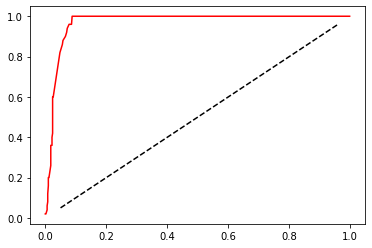

In [42]:
# 开始绘图
recall=[]
FPR=[]
probarange=np.linspace(clf_proba.predict_proba(X)[:,1].min(),clf_proba.predict_proba(X)[:,1].max(),55,endpoint=False)
from sklearn.metrics import recall_score,confusion_matrix
import matplotlib.pyplot as plt

for i in probarange:
    y_redict=[]
    for j in range(X.shape[0]):
        if clf_proba.predict_proba(X)[j,1]>i:
            y_redict.append(1)
        else:
            y_redict.append(0)
    cm=confusion_matrix(y,y_redict,labels=[1,0])
    recall.append(cm[0,0]/cm[0,:].sum())
    FPR.append(cm[1,0]/cm[1,:].sum())
    
recall.sort()
FPR.sort()

plt.plot(FPR,recall,c='red')
plt.plot(probarange+0.05,probarange+0.05,c='black',linestyle='--')
plt.show()

![title](C:\Users\Administrator\caicaidata\jietu\roc1.jpg)

![title](C:\Users\Administrator\caicaidata\jietu\auc.jpg)

In [68]:
import scikitplot as skplt

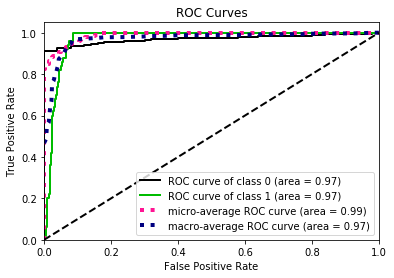

In [71]:
skplt.metrics.plot_roc(y,clf_proba.predict_proba(X))
plt.show()

In [43]:
from sklearn.metrics import roc_curve

In [44]:
FPR,recall,thresholds=roc_curve(y,clf_proba.decision_function(X),pos_label=1)

In [45]:
FPR

array([0.   , 0.   , 0.006, 0.006, 0.008, 0.008, 0.01 , 0.01 , 0.014,
       0.014, 0.018, 0.018, 0.022, 0.022, 0.024, 0.024, 0.028, 0.028,
       0.03 , 0.03 , 0.032, 0.032, 0.036, 0.036, 0.04 , 0.04 , 0.042,
       0.042, 0.044, 0.044, 0.05 , 0.05 , 0.054, 0.054, 0.058, 0.058,
       0.066, 0.066, 0.072, 0.072, 0.074, 0.074, 0.086, 0.086, 1.   ])

In [46]:
recall

array([0.  , 0.02, 0.02, 0.06, 0.06, 0.16, 0.16, 0.2 , 0.2 , 0.22, 0.22,
       0.36, 0.36, 0.42, 0.42, 0.6 , 0.6 , 0.62, 0.62, 0.64, 0.64, 0.68,
       0.68, 0.7 , 0.7 , 0.74, 0.74, 0.76, 0.76, 0.82, 0.82, 0.84, 0.84,
       0.86, 0.86, 0.88, 0.88, 0.92, 0.92, 0.94, 0.94, 0.96, 0.96, 1.  ,
       1.  ])

In [49]:
# thresholds 不是概率，是距离
thresholds

array([  3.18236076,   2.18236076,   1.48676267,   1.35964325,
         1.33920817,   1.14038015,   1.13383091,   1.00003406,
         0.85085628,   0.84476439,   0.78571364,   0.60568093,
         0.5389064 ,   0.46718521,   0.44396046,   0.03907036,
        -0.07011269,  -0.10668727,  -0.1258212 ,  -0.13845693,
        -0.14034183,  -0.16790648,  -0.2040958 ,  -0.22137683,
        -0.24381463,  -0.26762451,  -0.34446784,  -0.3467975 ,
        -0.39182241,  -0.40676459,  -0.4589064 ,  -0.46310299,
        -0.49195707,  -0.5088941 ,  -0.53560561,  -0.55152081,
        -0.62628865,  -0.67580418,  -0.78127198,  -0.79874442,
        -0.88438995,  -0.91257798,  -1.01417607,  -1.08601917,
       -10.31959605])

In [50]:
from sklearn.metrics import roc_auc_score as AUC

In [52]:
area=AUC(y,clf_proba.decision_function(X))

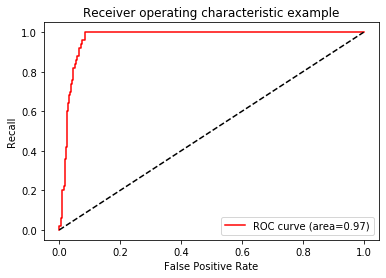

In [56]:
plt.figure()
plt.plot(FPR,recall,color='red',label='ROC curve (area=%0.2f)' % area)
plt.plot([0,1],[0,1],color='black',linestyle='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()

![title](C:\Users\Administrator\caicaidata\jietu\roc2.jpg)

![title](C:\Users\Administrator\caicaidata\jietu\yuzhi.jpg)

In [58]:
(recall-FPR).max()

0.914

In [61]:
maxindex=(recall-FPR).tolist().index((recall-FPR).max())

In [62]:
maxindex

43

In [65]:
# decision_fuction生成的置信度来说，最佳阈值
thresholds[maxindex]

-1.0860191749391461

In [66]:
FPR[maxindex]

0.086

In [67]:
recall[maxindex]

1.0

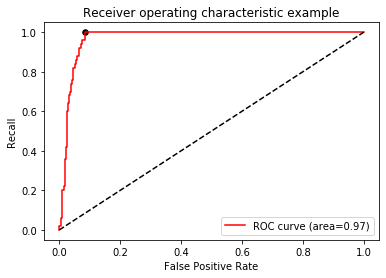

In [64]:
plt.figure()
plt.plot(FPR,recall,color='red',label='ROC curve (area=%0.2f)' % area)
plt.plot([0,1],[0,1],color='black',linestyle='--')
plt.scatter(FPR[maxindex],recall[maxindex],c='black',s=30)
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')
plt.show()

SVC 处理多分类问题：重要参数：decision_function_shape 

ovo：one versus one，一对一。即一对一的分类器，这时对K个类别需要构建K * (K - 1) / 2个分类器

ovr：one versus rest，一对其他，这时对K个类别只需要构建K个分类器。